# Importing required libraries

In [11]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Reading in the data

In [12]:
path = "data/preprocessed_data/csv_without_empty_cols_and_merged/"

In [13]:
test = pd.read_csv(path+"all_data.csv", index_col=0, na_values=[-9999, -99999])

C:\Users\mb335485\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
path = "data/preprocessed_data/csv_without_empty_cols_and_merged/"

df_tosa = pd.read_csv(path+"cof_tosa_aligner.csv", index_col=0, na_values=[-9999, -99999])
df_dctest = pd.read_csv(path+"cof_dctest.csv", index_col=0, na_values=[-9999, -99999], low_memory=False)
df_final = pd.read_csv(path+"final.csv", index_col=0, na_values=[-9999, -99999])


# Taking care of OsaSerialNum duplicates (DCTest)

In [15]:
# df_dctest.sort_values(by=["OsaSerialNum", "TestTimeStamp"], inplace=True)

In [16]:
# df_dctest.drop_duplicates(subset="OsaSerialNum", keep="last", inplace=True)

# Taking care of Containername duplicates (Tosa)

In [17]:
# df_tosa.sort_values(by=["Containername", "TestTimeStamp"], inplace=True)

In [18]:
# df_tosa.drop_duplicates(subset="Containername", keep="last", inplace=True)

# Dropping duplicates and almost empty rows from the output data

In [19]:
df_final.drop_duplicates(inplace=True)

# Instead of removing all rows that do not reach a certain threshhold of non-missing values, like we
# did in the other excercise before, I just dropped all rows that miss the value for "ModuleTxCalPower_dBm".
# This will remove the columns where all the output data are missing (but possibly also some other rows, if we
# are unlucky).
df_final.dropna(subset=["ModuleTxCalPower_dBm"], inplace=True)

# Merging the DataFrames

In [20]:
df_input = df_tosa.merge(df_dctest,
                         left_on="Containername",
                         right_on="OsaSerialNum",
                         suffixes=("_tosa", "_dctest"))

print(df_tosa.shape)
print(df_dctest.shape)
print(df_input.shape)

(33746, 32)
(33967, 84)
(37839, 116)


In [21]:
df_traceability = pd.read_excel("data/original_data/Linkage Map and Traceability.xlsx", "Traceability")

In [22]:
df_input = df_input.merge(df_traceability,
                          on="Component")

In [23]:
df_input.shape

(37839, 117)

In [24]:
df = df_input.merge(df_final,
                    left_on="ToContainer",
                    right_on="ModuleSerialNum",
                    suffixes=("","_final"))

# Removing ID columns

In [25]:
ids = list(df.filter(like="Id").columns)
ids += list(df.filter(like="HistoryID").columns)
print(ids)

df.drop(columns=ids, inplace=True)

['CDOTypeId_tosa', 'DataCollectionDefId_tosa', 'dc_COF_TOSA_AlignerHistoryId', 'HistoryId_tosa', 'HistoryMainlineId_tosa', 'TxnId_tosa', 'CDOTypeId_dctest', 'DataCollectionDefId_dctest', 'dc_COF_DCTestHistoryId', 'HistoryId_dctest', 'HistoryMainlineId_dctest', 'TxnId_dctest', 'dce_HistoryID_tosa', 'ParentHistoryID_tosa', 'dce_HistoryID_dctest', 'ParentHistoryID_dctest']


# Removing columns without variance

In [26]:
# Dropping columns without variance
dropped_columns = []

for c in df.columns:
    count_of_unique_values = len(df[c].dropna().unique())
    if count_of_unique_values == 1:      
        df.drop(columns=c, inplace=True)
        dropped_columns.append(c)
        
print("Columns without variance: %s" % dropped_columns)

df.shape

Columns without variance: ['EngrDataDefID_tosa', 'ParentTableID_tosa', 'ChangeCount_tosa', 'PartNum', 'TestOperator_tosa', 'WhichTest_tosa', 'EngrDataDefID_dctest', 'ParentTableID_dctest', 'FXT_VCSL', 'Wavelength_nm', 'BaseAssemblyNum', 'BasePartNum', 'ChangeCount_dctest', 'IsRetest', 'OsaPartNum', 'Rework', 'TestPlanDate', 'TestPlanName', 'TestPlanVersion', 'WhichTest_dctest']


(37786, 97)

In [27]:
df.to_csv("data_for_modelling.csv")

# Classification

## Preparing input and output data

In [28]:
df = df[df.groupby("ErrAbbr")["ErrAbbr"].transform(len) > 100]
df = df[(df["ErrAbbr"] != "PASS")]

In [29]:
X = df.drop(columns=df_final.columns)
y = df["ErrAbbr"]

## Estimating missing input data

In [30]:
# Handling missing values
X.dropna(axis=1, how="all", inplace=True)
X.fillna(X.median(), inplace=True)

## Transforming the categorical variables

In [31]:
categorical_variables = ["TestStation_tosa", "TestStation_dctest", "Site", "Att_bins", "SlotNum"]

X = pd.get_dummies(X, columns=categorical_variables)
X = X.select_dtypes(exclude=object)

In [32]:
for c in X.columns:
    print(c)

LDPWR_mWs
AliPwr_mWs
CurePwr_mWs
ITH_mA
Slope_Eff
LD_Res
LD_Volt
CALF_COMP
CALF_CONN
T_PO_W
ID_PD_A
BVR_PD_V
BOND_A
BVR_LD_A
SNP_BK
PO_LD_W
VF_LD_V
PO_PCT
SLOPE_WperA
KINK
CORREL
THOLD_A
ROLL
I_NOM_A
IL_PD_A
R_LD_ohm
TRACK8_AperW
TRACK10_AperW
TRACK12_AperW
TRACK15_AperW
DELTRK
PO_H_W
PO_L_W
KINK1
KINK2
WIGGLE_dB
FFT
KINKMULT1
IMAX_A
KINKMULT2
PMAX_W
KINK2BETTER
VI_MASK
VI_KINK
PO_PCT2
T_PO_dBm
PO_LD_dBm
BMRipStd
Wiggle_pMin_W
WIGGLE_pMax_W
TestDuration_s
TestResult
TestStation_tosa_AT-ALIGNCOFT-01
TestStation_tosa_AT-ALIGNCOFT-02
TestStation_tosa_AT-ALIGNCOFT-03
TestStation_tosa_AT-ALIGNCOFT-04
TestStation_tosa_AT-ALIGNCOFT-05
TestStation_tosa_AT-ALIGNCOFT-06
TestStation_tosa_AT-ALIGNCOFT-07
TestStation_tosa_AT-ALIGNCOFT-08
TestStation_tosa_AT-ALIGNCOFT-09
TestStation_tosa_AT-ALIGNCOFT-10
TestStation_dctest_IPH_COFT_01
TestStation_dctest_IPH_COFT_02
TestStation_dctest_IPH_COFT_03
TestStation_dctest_IPH_COFT_04
TestStation_dctest_IPH_COFT_05
TestStation_dctest_IPH_COFT_06
TestStation_d

In [33]:
with pd.option_context('display.max_columns', 150):
    display(X.head())

,LDPWR_mWs,AliPwr_mWs,CurePwr_mWs,ITH_mA,Slope_Eff,LD_Res,LD_Volt,CALF_COMP,CALF_CONN,T_PO_W,ID_PD_A,BVR_PD_V,BOND_A,BVR_LD_A,SNP_BK,PO_LD_W,VF_LD_V,PO_PCT,SLOPE_WperA,KINK,CORREL,THOLD_A,ROLL,I_NOM_A,IL_PD_A,R_LD_ohm,TRACK8_AperW,TRACK10_AperW,TRACK12_AperW,TRACK15_AperW,DELTRK,PO_H_W,PO_L_W,KINK1,KINK2,WIGGLE_dB,FFT,KINKMULT1,IMAX_A,KINKMULT2,PMAX_W,KINK2BETTER,VI_MASK,VI_KINK,PO_PCT2,T_PO_dBm,PO_LD_dBm,BMRipStd,Wiggle_pMin_W,WIGGLE_pMax_W,TestDuration_s,TestResult,TestStation_tosa_AT-ALIGNCOFT-01,TestStation_tosa_AT-ALIGNCOFT-02,TestStation_tosa_AT-ALIGNCOFT-03,TestStation_tosa_AT-ALIGNCOFT-04,TestStation_tosa_AT-ALIGNCOFT-05,TestStation_tosa_AT-ALIGNCOFT-06,TestStation_tosa_AT-ALIGNCOFT-07,TestStation_tosa_AT-ALIGNCOFT-08,TestStation_tosa_AT-ALIGNCOFT-09,TestStation_tosa_AT-ALIGNCOFT-10,TestStation_dctest_IPH_COFT_01,TestStation_dctest_IPH_COFT_02,TestStation_dctest_IPH_COFT_03,TestStation_dctest_IPH_COFT_04,TestStation_dctest_IPH_COFT_05,TestStation_dctest_IPH_COFT_06,TestStation_dctest_IPH_COFT_07,TestStation_dctest_IPH_COFT_08,TestStation_dctest_IPH_COFT_09,Site_0,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Att_bins_-1,Att_bins_0,Att_bins_1,Att_bins_2,Att_bins_3,Att_bins_4,Att_bins_5,SlotNum_0.0,SlotNum_1.0,SlotNum_2.0,SlotNum_3.0,SlotNum_4.0,SlotNum_5.0,SlotNum_6.0,SlotNum_7.0,SlotNum_8.0,SlotNum_9.0
13,3.3820,0.5775,0.5660,0.0,0.0,0.0,0.0,2.0401,1.9964,0.000402,2.131228e-09,31.005,2.085000e-08,1.208360e-09,0.0,0.000337,2.076523,83.72990,0.047092,0.557364,0.999624,0.001061,-2.528080,0.0135,0.000552,52.78397,1.713896,1.615484,1.562788,1.521265,0.941677,0.000536,0.000484,50.51240,233.0817,0.126665,0.169505,129.91130,0.0200,2.113647,0.000774,6.166465,0.0,5.769901,83.06193,-3.956720,-4.727914,0.295899,0.000334,0.000344,22,-10293,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
14,3.3820,0.5775,0.5660,0.0,0.0,0.0,0.0,2.0071,2.0109,0.000603,7.796370e-10,31.001,3.990000e-09,4.498360e-10,0.0,0.000536,2.080706,88.89952,0.068550,0.689251,0.999669,0.000910,-4.386859,0.0089,0.000551,53.26843,1.025409,1.035641,1.027327,1.019694,0.984602,0.000806,0.000729,26.26116,173.4647,0.083197,0.363242,119.56060,0.0199,2.077588,0.001058,5.800860,0.0,5.896650,87.46564,-2.194358,-2.705364,0.261453,0.000528,0.000538,25,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
27,3.3765,0.0000,0.0000,0.0,0.0,0.0,0.0,2.0401,1.9964,0.000621,3.127711e-09,31.011,1.619000e-08,6.474027e-10,0.0,0.000561,2.075640,90.38322,0.071896,0.765628,0.999524,0.000916,-5.415378,0.0085,0.000531,52.64173,0.969051,0.941226,0.962550,0.958889,1.018765,0.000833,0.000767,28.24946,100.4635,0.107034,0.368255,76.91773,0.0200,1.886027,0.001087,5.804416,0.0,5.778452,88.24277,-2.071950,-2.511072,0.408408,0.000548,0.000561,22,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
28,3.3765,0.5716,0.5603,0.0,0.0,0.0,0.0,2.0401,1.9964,0.000621,3.127711e-09,31.011,1.619000e-08,6.474027e-10,0.0,0.000561,2.075640,90.38322,0.071896,0.765628,0.999524,0.000916,-5.415378,0.0085,0.000531,52.64173,0.969051,0.941226,0.962550,0.958889,1.018765,0.000833,0.000767,28.24946,100.4635,0.107034,0.368255,76.91773,0.0200,1.886027,0.001087,5.804416,0.0,5.778452,88.24277,-2.071950,-2.511072,0.408408,0.000548,0.000561,22,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
103,3.3221,0.5672,0.5653,0.0,0.0,0.0,0.0,2.0352,2.0120,0.000632,2.196320e-09,31.004,1.854000e-08,3.018457e-10,0.0,0.000564,2.092213,89.36993,0.072621,0.633654,0.999375,0.000877,-5.383078,0.0084,0.000567,54.28913,1.021971,0.993983,1.018520,0.987671,0.993650,0.000841,0.000769,28.81562,435.9929,0.141585,0.471527,276.26880,0.0200,2.441332,0.001066,6.380777,0.0,5.758220,86.92415,-1.995694,-2.483780,0.449284,0.000549,0.000567,22,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## Creating a classification model

### Splitting in training and testing data

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### KNN Classifier

#### Training a KNN classifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### Making predictions

In [38]:
y_pred = clf.predict(X_test)

df_results = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})

df_results

,y_pred,y_test
13653,TxCal,RxMsk
26269,-1732,RxMsk
12433,RxMsk,-1732
12417,RxMsk,-1732
7380,LoPwr,-1732
23296,-1732,TxCal
30743,-1732,-1732
25626,TxCal,TxCal
26362,LoPwr,LoPwr
29172,-1732,LoPwr


#### Evaluating the KNN classifier

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [40]:
print("Accuracy: %s" % accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy: 0.3333333333333333
[[11  2  3  5]
 [ 5  4  4  3]
 [ 7  2  3  3]
 [ 9  1  6  7]]


#### Cross-validation

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [42]:
cv = ShuffleSplit(n_splits=10, test_size=0.1)

print(cross_val_score(clf, X, y, cv=cv))

print(cross_val_score(clf, X, y, cv=cv).mean())

[0.36       0.30666667 0.26666667 0.26666667 0.29333333 0.32
 0.38666667 0.34666667 0.38666667 0.28      ]
0.3306666666666667


### Random Forest Classifier

#### Training the Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Making predictions

In [45]:
y_pred = clf.predict(X_test)

df_results = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})

df_results

,y_pred,y_test
13653,LoPwr,RxMsk
26269,TxCal,RxMsk
12433,-1732,-1732
12417,LoPwr,-1732
7380,TxCal,-1732
23296,-1732,TxCal
30743,-1732,-1732
25626,TxCal,TxCal
26362,-1732,LoPwr
29172,LoPwr,LoPwr


#### Evaluating the Random Forest

In [46]:
print("Accuracy: %s" % accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5066666666666667
[[15  4  0  2]
 [ 4  8  3  1]
 [ 6  4  4  1]
 [ 7  2  3 11]]


#### Cross-validation

In [47]:
cv = ShuffleSplit(n_splits=10, test_size=0.1)

print(cross_val_score(clf, X, y, cv=cv))

print(cross_val_score(clf, X, y, cv=cv).mean())

[0.42666667 0.33333333 0.48       0.45333333 0.48       0.4
 0.38666667 0.48       0.42666667 0.52      ]
0.44266666666666665


#### Model Tuning

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
# initializing the model
rand_forr = RandomForestClassifier()

# specifying parameters to tune
param_grid = {"n_estimators": [5, 10, 15, 20, 40, 50, 75, 100]}

clf = GridSearchCV(rand_forr, param_grid=param_grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)

# training
clf.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 15, 20, 40, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [50]:
# get the best models parameters and score
print("Best parametersc(SVM): %s" % clf.best_params_)
print("Best score (SVM): %s" % clf.best_score_)

Best parametersc(SVM): {'n_estimators': 50}
Best score (SVM): 0.4852941176470588


In [51]:
# making predictions with the optimized model

y_pred = clf.predict(X_test)

df_results = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})

df_results


,y_pred,y_test
13653,LoPwr,RxMsk
26269,-1732,RxMsk
12433,-1732,-1732
12417,LoPwr,-1732
7380,TxCal,-1732
23296,-1732,TxCal
30743,-1732,-1732
25626,TxCal,TxCal
26362,RxMsk,LoPwr
29172,LoPwr,LoPwr


In [52]:
# Checking the performance of our model on unseen data

print(confusion_matrix(y_test, y_pred))

print(accuracy_score(y_test, y_pred))


[[17  1  0  3]
 [ 2 12  1  1]
 [ 8  4  3  0]
 [ 9  2  3  9]]
0.5466666666666666


#### Some ideas that might improve your model
- Feature engineering: Create new features, e.g. transform a continuous variable into a discrete one (for instance create a new variable x_is_critical that is 1 if the original variable x exceeds a critical value and 0 if it doesn't)
- Use your domain knowledge to drop irrelevant input variables
- Combine models: Maybe one model is very good at predicting a certain error type. Use this model to just predict if this particular error will occur. If the model predicts that this error will not occur, feed the input data into a second model that predicts which of the remaining possible errors will happen.
- Have a look at statistical outliers (you could find those for example using boxplots) and decide whether they should be removed or kept
- Check for other data that should be removed (for instance you mentioned that sometimes the same product is tested multiple times. Here you should use the data that is likely to be the most valid.)
- If you want to predict extremely imbalanced data (e.g. your data contain lots of PASS values but relatively few errors), you need to compensate for the imbalance. For instance, you could under-sample the majority class or over-sample the minority class.

#### Interesting feature of tree models, such as Random Forest --> feature importances

The feature importances can be used to see which features contributed the model. PLEASE, BE AWARE: A HIGH FEATURE IMPORTANCE DOES NOT NECESSARILY MEAN THAT A CERTAIN FEATURE HAS A STRONG INFLUENCE ON THE OUTPUT. It is just means that the feature contributed to improving the model's accuracy!

Feature importances can be used for reverse feature selection (dropping features that have a low importance one by one and see how the model changes, if it is re-trained with the reduced feature set)

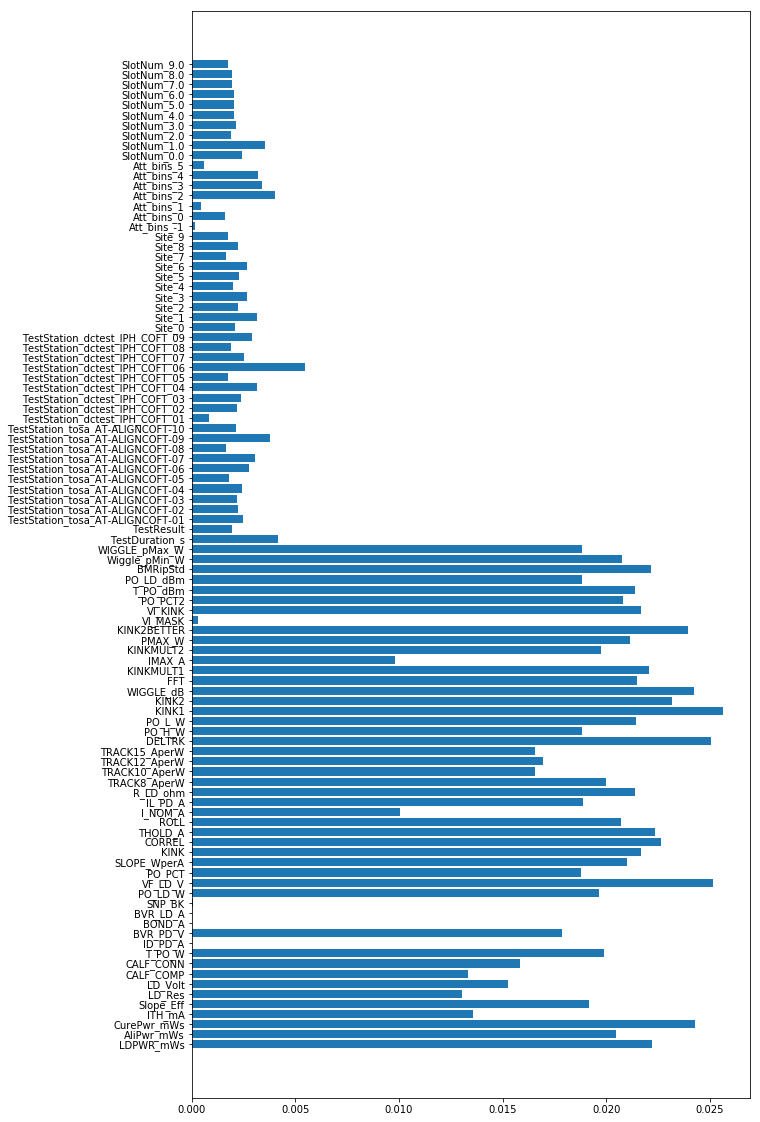

In [1630]:
# get the best model from the GridSearchCV object
model = clf.best_estimator_

# get feature importances
fi = model.feature_importances_
col_names = X.columns

import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.barh(col_names, fi)
plt.show()

# Regression

## Prepare input and output data

In [1648]:
df = pd.read_csv("data_for_modelling.csv", index_col=0)
df.dropna(subset=["TxOma_mW"], inplace=True)

In [1649]:
y = df["TxOma_mW"]
X = df.drop(columns=df_final.columns)

# Handling missing values
X.dropna(axis=1, how="all", inplace=True)
X.fillna(X.median(), inplace=True)

# Transforming categorical variables
categorical_variables = ["TestStation_tosa", "TestStation_dctest", "Site", "Att_bins", "SlotNum"]

X = pd.get_dummies(X, columns=categorical_variables)
X = X.select_dtypes(exclude=object)

# Remove remaining categorical data
X = X.select_dtypes(exclude=object)

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [1652]:
print(X.shape)

(30119, 98)


## Training the regression model

In [1650]:
from sklearn.ensemble import GradientBoostingRegressor

In [1692]:
gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=10)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

## Making predictions

In [1693]:
y_pred = gbr.predict(X_test)

In [1694]:
df_results = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})

df_results

,y_pred,y_test
6697,890.805735,905.358093
8298,855.279716,818.938538
29727,857.013844,900.023682
3360,831.641185,788.674988
3066,867.530161,853.032227
1155,902.233185,884.718201
21723,861.093405,867.158264
10683,775.628932,842.015259
19481,880.912442,893.920837
24704,865.224802,853.091553


## Model evaluation

In [1695]:
from sklearn.metrics import mean_absolute_error

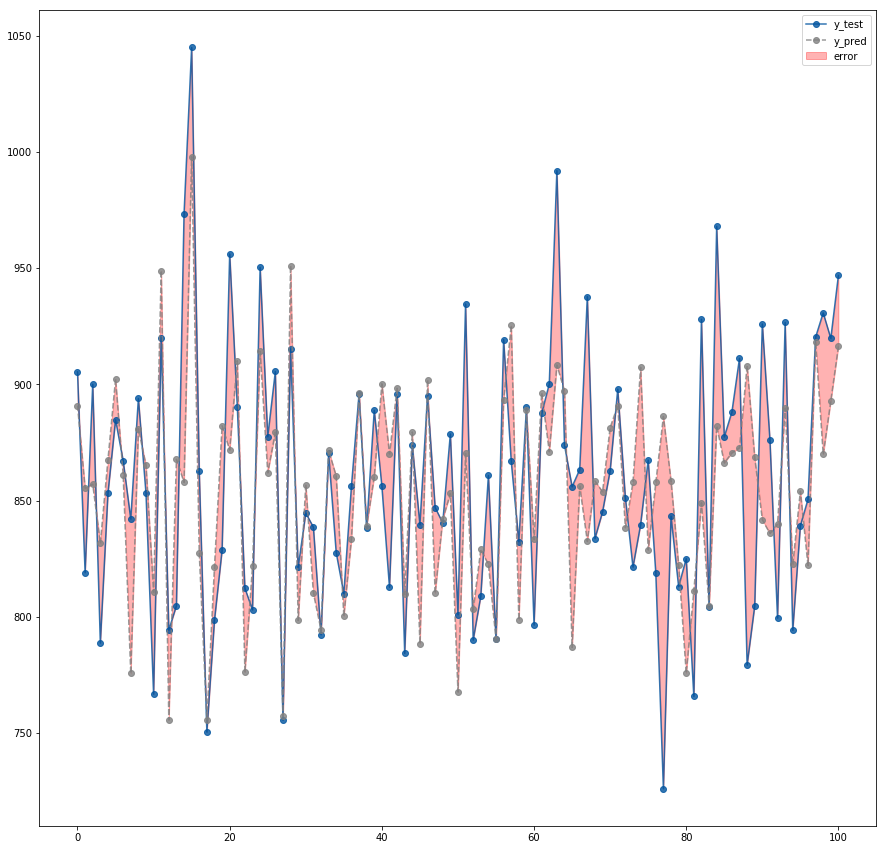

In [1696]:
plt.figure(figsize=(15,15))
df_results.reset_index(drop=True, inplace=True)

n = 100

df_results.loc[:n, "y_test"].plot(marker="o", color=(0/255, 84/255, 159/255), alpha=0.8, label="y_test")
df_results.loc[:n, "y_pred"].plot(marker="o", linestyle="--", color="gray", alpha=0.8, label="y_pred")
plt.fill_between(range(len(df_results.loc[:n, "y_pred"])),
                 df_results.loc[:n, "y_pred"],
                 df_results.loc[:n, "y_test"],
                 color="r",
                 alpha=0.3,
                 label="error")

plt.legend()

In [1697]:
mae = mean_absolute_error(y_test, y_pred)

print("Mean absolute error (MAE): %s" % (mae))
print("actual output variable has mean of %s and STD of %s" % (y_test.mean(), y_test.std()))

Mean absolute error (MAE): 38.98856510960182
actual output variable has mean of 854.0872579425138 and STD of 62.05567218277861


## Model tuning

In [ ]:
# initializing the model
rand_forr = RandomForestClassifier()

# specifying parameters to tune
param_grid = {"n_estimators": [100, 300, 500],
              "max_depth": [3, 5, 10]}

clf = GridSearchCV(rand_forr, param_grid=param_grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)

# training
clf.fit(X_train, y_train)

In [ ]:
# get the best models parameters and score
print("Best parametersc(SVM): %s" % regr.best_params_)
print("Best score (SVM): %s" % regr.best_score_)

In [ ]:
# making predictions with the optimized model

y_pred = regr.predict(X_test)

df_results = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})

df_results


TypeError: Empty 'DataFrame': no numeric data to plot

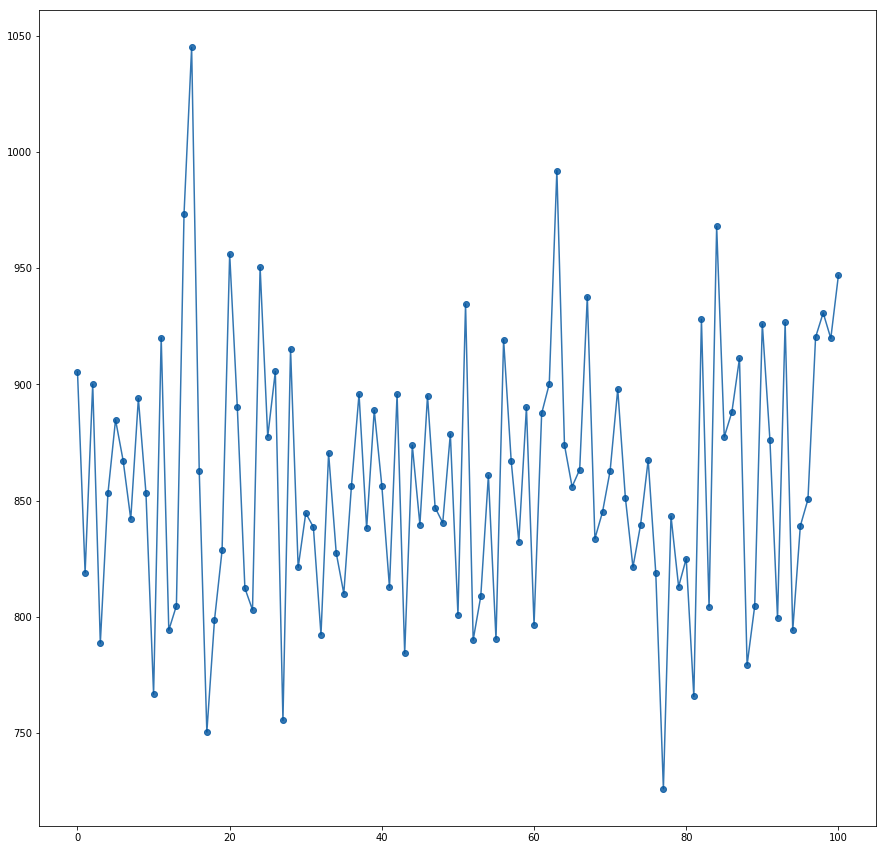

In [1679]:
plt.figure(figsize=(15,15))
df_results.reset_index(drop=True, inplace=True)

n = 100

df_results.loc[:n, "y_test"].plot(marker="o", color=(0/255, 84/255, 159/255), alpha=0.8, label="y_test")
df_results.loc[:n, "y_pred"].plot(marker="o", linestyle="--", color="gray", alpha=0.8, label="y_pred")
plt.fill_between(range(len(df_results.loc[:n, "y_pred"])),
                 df_results.loc[:n, "y_pred"],
                 df_results.loc[:n, "y_test"],
                 color="r",
                 alpha=0.3,
                 label="error")

plt.legend()

In [ ]:
mae = mean_absolute_error(y_test, y_pred)

print("Mean absolute error (MAE): %s" % (mae))
print("actual output variable has mean of %s and STD of %s" % (y_test.mean(), y_test.std()))